In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

# Import data

In [2]:
df = pd.read_csv("/home/yulius/Latihan-Data-Science/Data/taxi_fare.csv",parse_dates=["pickup_datetime"])
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


# EDA

In [3]:
pickup_dt = df.pickup_datetime.dt
df["year"] = pickup_dt.year
df["month"] = pickup_dt.month
df["day"] = pickup_dt.dayofweek
df["hour"] = pickup_dt.hour
df.drop(columns="pickup_datetime", inplace=True)

df["distance"] = np.abs(df.pickup_longitude-df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude)
df.drop(columns=["pickup_longitude","dropoff_longitude","pickup_latitude","dropoff_latitude"],inplace=True)
df.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


In [4]:
X = df.drop(columns="fare_amount")
y = df["fare_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15135, 6), (3784, 6), (15135,), (3784,))

# Training

In [5]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [7]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=3, transform='yeo-johnson'), ["passenger_count","year","distance"]),
    ('categoric', cat_pipe(encoder='onehot'), ["month","day","hour"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

model = RandomizedSearchCV(pipeline, rsp.enet_poly_params, cv=3, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.4min finished
/home/yulius/miniconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__alpha': 0.00012575549573395252, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.8095010461397156, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7219864295744891 0.718561556427816 0.7384730168938713


/home/yulius/miniconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179233.14261147036, tolerance: 140.46878127167486
  positive)


# Feature Importance

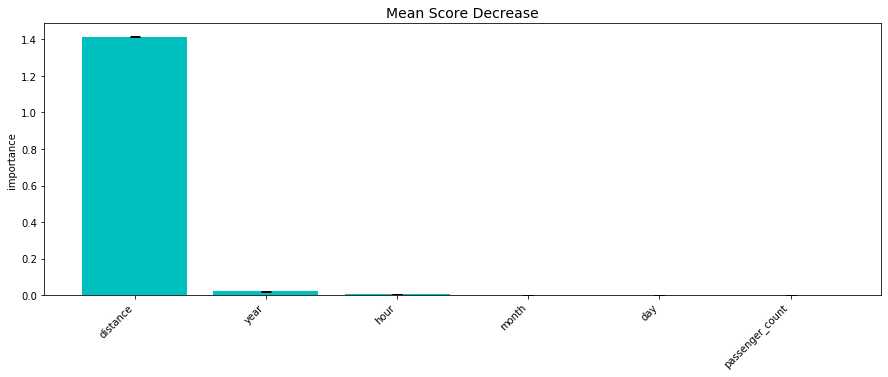

In [8]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

# Evaluation

In [9]:
from jcopml.plot import plot_actual_vs_prediction,plot_residual

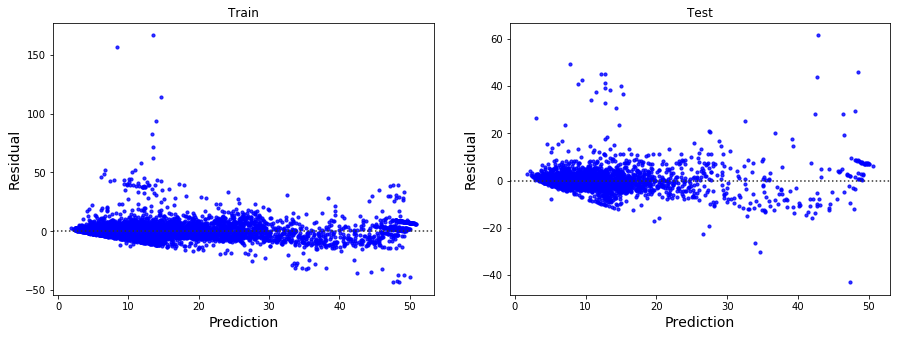

In [10]:
plot_residual(X_train, y_train, X_test, y_test, model)

## Cek data unbalance

In [11]:
df_analysis =X_train.copy()

pred = model.predict(X_train)
error = np.abs(pred - y_train)

df_analysis['Fare'] = y_train
df_analysis["error"] = error
df_analysis.sort_values("error", ascending=False).head(10)

,passenger_count,year,month,day,hour,distance,Fare,error
1335,1.0,2013,1,2,20,0.000000,180.00,166.557614
1483,1.0,2009,8,4,21,0.000416,165.00,156.586738
6630,1.0,2014,5,4,1,0.000000,128.83,114.135238
14142,1.0,2014,12,4,10,0.045860,108.00,94.128757
12915,1.0,2011,9,2,1,0.000000,96.00,82.611938
18150,1.0,2011,12,3,22,0.000000,85.00,71.538937
10524,1.0,2010,5,1,14,0.000000,75.80,62.239337
1494,1.0,2009,9,1,14,0.000031,70.00,58.240111
2346,1.0,2009,2,5,0,0.000000,63.00,52.088207
2432,1.0,2012,11,4,1,0.003817,58.60,51.999239
